# **Analyse de sentiments sur les films du TOP 100 box office**
**Projet Python - 2A ENSAE**

✍️ AUMONT Louis-Armand, KHAIRALDIN Ahmed, GIMENES Vincent

# Problématique: Peut-on prédire la note d'un film à partir d'informations de base et de l'analyse de commentaires sur celui-ci ?  🧐

## Sommaire

* **[1. Récupération des données](#chapter1)**
  * [1.1 Scraping sur une page donnée](#section_1_1)
  * [1.2 Scraping des 100 pages de film](#section_1_2)
  * [1.3 Premiers traitements de la base de données](#section_1_3)
* **[2. Traitement des données](#chapter2)**
  * [2.1 Création de la base de données des commentaires](#section_2_1)
  * [2.2 Tokenisation et lemmatisation](#section_2_2)
    * _[2.2.1 Tokenisation et suppression de la ponctuation](#section_2_2_1)_
    * _[2.2.2 Lemmatisation des commentaires](#section_2_2_2)_
  * [2.3 Représentation des mots](#section_2_3)
  * [2.4 NLP et analyse de sentiments](#section_2_4)
    * _[2.4.1 Algorithmes d'analyse de sentiments](#section_2_4_1)_
    * _[2.4.2 Création d'un nouveau dataset](#section_2_4_2)_
* **[3. Analyse descriptive et étude économétrique](#chapter3)**
  * [3.1 Etude statistique du DataFrame](#section_3_1)
    * _[3.1.1 Variables numériques](#section_3_1_1)_
      * _[3.1.1.1 Les notes](#section_3_1_1_1)_
      * _[3.1.1.2 Budget et Box Office](#section_3_1_1_2)_
      * _[3.1.1.3 La durée des films](#section_3_1_1_3)_
    * _[3.1.2 Variables textuelles](#section_3_1_2)_
      * _[3.1.2.1 Autour de la distribution des scores de polarité](#section_3_1_2_1)_
      * _[3.1.2.2 Distribution de la variance des scores des sentiments](#section_3_1_2_2)_
    * _[3.1.3 Intéraction entre les variables](#section_3_1_3)_
      * _[3.1.3.1 Pairgrid](#section_3_1_3_1)_
    * _[3.1.4 Scatterplot](#section_3_1_4)_
  * [3.2 Etude économétrique](#section_3_2)
    * _[3.2.1 Matrice de corrélation](#section_3_2_1)_
    *  _[3.2.2 Les scores calculés par l'algorithme de Textblob restent-t-ils cohérents avec la note imbd des films ?](#section_3_2_2)_
    *  _[3.2.3 Est-ce que plus un film est long, plus les commentaires seront négatifs ?](#section_3_2_3)_
    *  _[3.2.4 Le budget d'un film a-t-il un effet sur le score de polarité?](#section_3_2_4)_
    *  _[3.2.5 Avons-nous des résultats différents en considérant cette fois comme variable à expliquer directement les notes?](#section_3_2_5)_
    *  _[3.2.6 Autour de la variable de variance des scores de polarité "var_score_blob"](#section_3_2_6)_
* **[4. Modélisation](#chapter4)**
  * [4.1 Pre-Processing](#section__4_1)
  * [4.2 Modèle de régression multiple](#section_4_2)
  * [4.3 Amélioration du modèle](#section_4_3)
* **[Conclusion](#conclusion)**

###  Téléchargement des librairies ⚙️

In [1]:
# Pour la partie I

!pip install -q lxml 
!pip install selenium

# Pour la partie II

!pip install spacy
!pip install wordcloud
!pip install textblob
!pip install nltk

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'L:\\ProgramData\\Anaconda\\Lib\\site-packages\\wordcloud'
Consider using the `--user` option or check the permissions.



ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'L:\\ProgramData\\Anaconda\\Lib\\site-packages\\textblob'
Consider using the `--user` option or check the permissions.



###  Import des librairies 📦

In [1]:
# Pour la partie I
import time
import requests
import numpy as np
import pandas as pd
import urllib
from urllib import request
import bs4 
import lxml

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Pour la partie II
import json
import nltk
import spacy
import matplotlib.pyplot as plt


from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pour la partie III
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

ModuleNotFoundError: No module named 'textblob'

In [3]:
# Téléchargement d'éléments nécessaires à la tokenisation
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

!python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/onyxia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


<h1> 1 - Récupération de données </h1> <a class="anchor" id="chapter1"></a>

Cette première partie a pour but de récupérer des données sur le top 100 box office via le site imdb: https://www.imdb.com/. Pour ce faire, nous allons "scraper" les données grâce à la library selenium qu'il faut télécharger. Elle nous permettra d'interagir avec des éléments dynamiques sur le site.

<span style="font-size:larger;"> ⚠️ **Important** ⚠️</span>
️


**Il faut également télécharger un "chromedriver" de la même version que votre version Chrome, et le mettre à coté de ce fichier jupyter dans les fichiers. Lien pour télécharger les chromedrivers: https://googlechromelabs.github.io/chrome-for-testing/. Ma version Chrome était la  119.0.6045.--- et la version de mon chromedriver était la même, celle de windows.**

<h2> 1.1 Scraping sur une page donnée </h2> <a class="anchor" id="section_1_1"></a>

Nous allons d'abord écrire une fonction qui va récupérer les informations et les commentaires à partir du lien de la page principale d'un film donné. Nous réutiliserons cette fonction dans une boucle pour "scrap" les films de notre liste de façon automatique.
Pour ce faire, nous avons commencé par travailler sur cette page: https://www.imdb.com/title/tt0499549/?ref_=ttls_li_tt

Globalement, notre code créera un robot qui va simuler l'utilisation du navigateur chrome. Dans notre fonction "scrape_imdb_reviews", nous dictons à notre robot de se rendre sur le lien que nous lui donnons en entrée. A partir de là, il va récuperer certaines informations sur le film, comme son titre, sa durée, sa note globale, son budget, etc...

Ensuite, nous lui demandons d'un peu scroller vers le bas pour faire apparaître un bouton "avis d'utilisateurs". Il clique dessus, clique sur le bouton "hide spoilers" pour retirer les commentaires avec une banière "warning: spoilers" (Ils sont plus difficiles à scraper et pas forcément importants dans notre cas), puis il va aller cliquer plusieurs fois tout en bas des commentaires sur "load more" afin de charger plus de commentaires (25 de plus par "load more" cliqués). Le paramètre va "num_iterations" va en fait correspondre au nombre de fois où le robot va cliquer sur "load more". Le robot scrape ensuite tous les commentaires affichés.

Enfin le robot nous retourne un dictionnaire avec pour clé le titre du film et pour valeurs une liste avec nos variables "scraped".

In [2]:
# Fonctions que l'on va appeler ensuite pour récupèrer des éléments dans une page html avec selenium

def get_element_byclass(code_name, driver_wait):
    span_element = driver_wait.until(EC.presence_of_element_located((By.CLASS_NAME, code_name)))
    return span_element.text

def get_element_bycss(code_name, driver_wait):
    span_element = driver_wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, code_name)))
    return span_element.text

In [9]:
def scrape_imdb_reviews(url, with_driver = None, num_iterations=3, wait_time=20):

    """

    Cette fonction prend en entrée l'url d'une page d'un film sur IMDB et retourne un dictionnaire,
    ayant en clée le titre du film et en valeur une liste contenant les commentaires, l'année, la note, le budget, 
    les recettes, et la durée du film.
    
    """
    if with_driver is None:
        driver = webdriver.Chrome()
    else:
        driver = with_driver
    driver.get(url)
    
    wait = WebDriverWait(driver, wait_time)
    
    ### MODIFICATION POUR PASSER LE COOKIE ###
    
    try:
        # Trouve le bouton par sa classe et son attribut data-testid
        accept_button = driver.find_element(By.CSS_SELECTOR, "button.icb-btn.sc-bcXHqe.sc-dkrFOg.sc-iBYQkv.dcvrLS.ddtuHe.dRCGjd[data-testid='accept-button']")

        # Clique sur le bouton
        accept_button.click()

        print("Bouton Accept cliqué avec succès!")


    except Exception as e:
        print(f"Erreur lors du clic sur le bouton de cookie")

        
    ### FIN MODIFICATION ###
    
    # Récupère le titre du film et son année de sortie
    title_htlm = wait.until(EC.presence_of_element_located((By.TAG_NAME, 'title')))
    title_imdb = title_htlm.get_attribute('text')
    title = title_imdb.replace(' - IMDb','') 
    print("Title:", title)
    
    # Année de sortie
    splitted = title.split()
    annee = splitted[-1].replace('(','').replace(')','')
    print(annee)
    
    # Récupère la note globale du film
    note = get_element_byclass("sc-bde20123-1", wait)
    print(note)
    
    try:
        # Récupère le budget estimé du film
        budget_ = get_element_bycss('.ipc-metadata-list__item[data-testid="title-boxoffice-budget"] .ipc-metadata-list-item__list-content-item', wait)
        budget = budget_.replace('\u202f','').replace(" $US(estimation)","")
        print(f"Budget: {budget}")
    
    # Récupère le box-office
        recette_ = get_element_bycss('.ipc-metadata-list__item[data-testid="title-boxoffice-cumulativeworldwidegross"] .ipc-metadata-list-item__list-content-item', wait)
        recette = recette_.replace('\u202f','').replace(" $US", "")
        print(f"Cumulative Worldwide Gross: {recette}")
    except Exception:
        budget = np.nan
        recette = np.nan
    
    
    # Récupère la durée du film
    duree_htlm = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'meta[property="og:description"]')))
    duree_ = duree_htlm.get_attribute('content')
    duree= duree_.split('|')[0].strip()
    print(duree)
    
    time.sleep(1)
    
    #Il faut scroller vers le bas pour pouvoir cliquer sur le bouton "avis d'utilisateurs"
    
     # Position du scroll
    current_scroll_position = driver.execute_script("return window.scrollY;")
    # Scroll vers le bas de 400 pixels du la position actuelle
    scroll_by_pixels = 800
    new_scroll_position = current_scroll_position + scroll_by_pixels
    driver.execute_script(f"window.scrollTo(0, {new_scroll_position});")
    time.sleep(1.5)
    
    
    try:
        # Cherche le bouton "avis d'utilsateurs" et clique de dessus.
        user_comments_button = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "span.three-Elements > span.label")))
        user_comments_button.click()
      
        # Cherche le bouton "Hide Spoilers" et clique sur ce bouton
        spoiler_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "faceter-facets-text")))
        spoiler_button.click()
    
        try:
            # Clique sur le bouton "Load More" plusieurs fois
            for i in range(num_iterations):
                load_more_button = wait.until(EC.element_to_be_clickable((By.ID, "load-more-trigger")))
                load_more_button.click()
                driver.implicitly_wait(3)

            time.sleep(2)
        
        finally:
            # Trouve les commentaires par classe CSS
            reviews = driver.find_elements(By.CSS_SELECTOR, ".text.show-more__control")
            reviews_txt = [review.text for review in reviews]
 
        # Imprime le nombre total de commentaires récupérés
        print(f"Nombre total de commentaires : {len(reviews)}")
    
    except Exception:
        reviews_txt = np.nan

    time.sleep(2)

    # Ferme le navigateur si pas de driver en entrée
    if with_driver is None:
        driver.quit()

    return {title: [reviews_txt, annee, note, budget, recette, duree]}

Test sur le film avatar: https://www.imdb.com/title/tt0499549/

In [10]:
url_avatar = "https://www.imdb.com/title/tt0499549/"
df_avatar = scrape_imdb_reviews(url_avatar, num_iterations=3, wait_time=20)

# Renvoie une erreur si vous n'avez pas le chromedriver

Bouton Accept cliqué avec succès!
Title: Avatar (2009)
2009

Budget: 237000000
Cumulative Worldwide Gross: 2923706026
2h 42m
Nombre total de commentaires : 100


In [11]:
# vérification
#print les 2 premiers commentaires
df_avatar['Avatar (2009)'][0][:2]

["I was waiting for this day for the longest time. I was a kid back in 2009 when this movie released. So never got to watch it back then. But now when it rereleased I booked the first day show to a IMAX show and oh boy was I blown away! This is nothing short of a masterpiece! It's beyond belief how a film like this could've been made. Every scene, every shot is perfection. You are transferred to a different world and become so engrossed in the film. Never have I attended a movie where at the end of it people got up from their seats and started clapping! Last time this happened was after Infinity War. That movie too was a damn brilliant one. I'm from India and this is legit rare, where people go crazy, so crazy after any English film. This was one experience that I will never forget. I'm definitely going for it again next weekend cuz just once was not enough.\n\nEvery human on the planet needs to experience this magnificent work of art!",
 "Forgive me, I'm going to jump from professiona

In [12]:
# Vérification que nous avons pas de commentaire "vide"
X = np.array([len(review) for review in df_avatar["Avatar (2009)"][0]])
print(len(X))
print(X)

100
[ 945 5506 2389 4167 1033 2754 5675 2022 1922 2429 3585 1352  997  850
 3852 1305  184 1047 1724  824 1275 2433 4197 1014 5140 1856 2332 2867
 2324 5172 1030 2689 4866  184 2714  715 2715 4956 1662 2300  820 4488
  767 2884 2559 4741 2492 1159 1759 1268 5574 1679 3027  765  992 4081
 1418  426  820 5216 1440  753  397  296 1259  550  802  743 1211 2292
  792 1416 1578 2094 3903  972 1049  403 5415 1263 3298  903  484 2565
  477  781 1482 1119  719 2289 3680  817 1361  254 2203  769 1792 1039
 3628 2152]


Nous vérifions bien que nous avons récupéré nos 100 commentaires

In [13]:
# Test pour un autre film, sur une page htlm que nous avions pas vu
url_cars = "https://www.imdb.com/title/tt0317219/?ref_=nv_sr_srsg_0_tt_8_nm_0_q_cars"
reviews_cars = scrape_imdb_reviews(url_cars, num_iterations=3, wait_time=20)

Bouton Accept cliqué avec succès!
Title: Cars - Quatre roues (2006)
2006

Budget: 120000000
Cumulative Worldwide Gross: 461991867
1h 57m
Nombre total de commentaires : 100


En faisant tourner la fonction "scrap_review_all" (en dessous), notre fonction s'est arrêtée sur le film "La bataille du lac Changjin" (https://www.imdb.com/title/tt13462900/?ref_=ttls_li_tt). En effet, sur la page du film, il n'y a pas le bouton "metascore" près du bouton "avis d'utilisateurs", ce qui fausse notre algorithme. Nous avons donc modifié notre fonction "scrape_imdb_reviews" en conséquence en mettant un systeme de "try - except " afin que notre fonction continue malgré tout. Les commentaires ne peuvent donc pas être scrapés sur ce genre de page avec notre algorithme (Cela pourrait être modifié mais ce problème concerne très peu de film) et nous remplaçons les commentaires initialement attendus par un "np.nan".

In [ ]:
#vérification
url_changjin = "https://www.imdb.com/title/tt13462900/?ref_=ttls_li_tt"
reviews_changjin = scrape_imdb_reviews(url_changjin, num_iterations=7, wait_time=20)
print(reviews_changjin.items())

<h2> 1.2 Scraping des 100 pages de film </h2> <a class="anchor" id="section_1_2"></a>

In [7]:
# Pour interrompre l'execution des cellules en chaines
raise KeyboardInterrupt

KeyboardInterrupt: 

<span style="font-size:larger;"> ⚠️ **Important** ⚠️</span>

<span style="color:red;">Les cellules suivantes vont consister au web scraping final des 100 films et à un rapide preprocessing. Cela prend approximativement 40-50min. Pour une lecture rapide, nous vous recommandons de simplement lire les cellules suivantes sans les executer jusqu'à la partie II où vous pourrez charger les data (que nous avons enregistrées sur github) en quelques secondes. </span>

Afin de pouvoir accéder aux films du top box office avec une boucle, il faut récupérer les liens pour chaque film. Pour ce faire, nous allons nous servir de ce site qui liste le top box office: https://www.imdb.com/list/ls098063263/. En le "scrapant" avec Beautifulsoup, nous pouvons récupérer les liens, ou plutôt les id dans les liens pour chaque film et ainsi faire une boucle. Le lien se retrouve avec "https://www.imdb.com" puis l'id du film puis "?ref_=tts_li_i". 

In [ ]:
#scraping de la page avec beautifulsoup.
main_url = 'https://www.imdb.com/list/ls098063263/'
request_text = request.urlopen(main_url).read()
page = bs4.BeautifulSoup(request_text, "lxml")

In [ ]:
def scrape_review_all(wait_time=10, num_iterations=3):
    # Initialise le navigateur
    driver = webdriver.Chrome()
    
    #créer un dico vide
    dico = {}
    
    #va récupérer les id dans les liens des films
    h3_tags = page.find_all('h3', class_='lister-item-header')
    i=1
    for h3_tag in h3_tags:
        a_tag = h3_tag.find('a')
        
        #id du film
        href_value = a_tag['href']
        
        #récupère l'url du film qui nous interesse avec l'id
        url = 'https://www.imdb.com'+href_value+'?ref_=ttls_li_i'
        
        dico.update(scrape_imdb_reviews(url, with_driver=driver, num_iterations=num_iterations, wait_time= wait_time))
        
        print(i)
        i+=1
        
        time.sleep(0.5)
    #ferme le navigateur
    driver.quit()
    return dico
        

In [ ]:
dico_all = scrape_review_all(wait_time=20, num_iterations=7)

**!!! La cellule ci-dessus prend environ 40 min à s'éxécuter. Assurer vous d'avoir du temps et une bonne connexion pour éviter tous problèmes.!!!**

Nous vérifions que nous avons bien récupérer ce qu'on voulait:

In [ ]:
print(dico_all.keys())
print(len(dico_all.keys()))
for i in dico_all.keys():
    #vérifie qu'il y a bien des commentaires et non un Nan
    if isinstance(dico_all[i][0], list):
        print( len(dico_all[i][0]))
    print(dico_all[i][1:])

Il y a bien nos 100 films, avec chacun environ 200 commentaires. Certains ont 175 commentaires "seulement" à cause de problèmes de connexion un peu aléatoires pour charger les pages. Il est peut-être possible d'arranger ce problème en laissant plus de temps à l'algorithme du dessus. Mais dans notre cas, ce problème concerne environ 5 films sur les 100. Donc nous allons nous contenter de cela.

<h2> 1.3 Premiers traitements de la base de données </h2> <a class="anchor" id="section_1_3"></a>

Il se trouve que les données finales avec 200 commentaires dépassent les 25Mo. Il devient alors (apparemment) impossible de les mettre sur Github. Nous avons donc fait une petite réduction à 185 commentaires par films au max pour passer sous la barre des 25Mo.

In [ ]:
# on crée une copie pour éviter de faire une erreur qui impliquerait de "re scrape" le dataset
copied_dict = dico_all.copy()

Les codes ci-dessous renvoient des erreurs mais fonctionnent quand même.

In [ ]:
#supprime les 186 eme et au-delà commentaires d'un film 
for i in copied_dict.keys():
    #vérifie qu'il y a bien des commentaires et non un Nan
     if isinstance(dico_all[i][0], list):
         if len(copied_dict[i][0])>186:
             del copied_dict[i][0][185:]

In [ ]:
#vérification
print(len(copied_dict.keys()))
for i in copied_dict.keys():
    #vérifie qu'il y a bien des commentaires et non un Nan
    if isinstance(dico_all[i][0], list):
        print( len(copied_dict[i][0]))
        print(copied_dict[i][1:])

In [ ]:
data_all = pd.DataFrame(copied_dict)

In [ ]:
data_all.to_json('data_reviews_1o2.json')

Maintenant que nous avons un premier fichier comportant les commentaires qu'on souhaite analyser, nous pouvons commencer le traitement de ces données et effectuer l'analyse de sentiment.

<h1> 2 - Traitement des données </h1> <a class="anchor" id="chapter2"></a>

L'objectif de cette partie va être de charger la base de données, puis nettoyer les commentaires pour les "tokeniser" et enfin les "lemmatiser" pour ensuite pouvoir appliquer des algorithmes de NLP sur nos commentaires "lemmatisés" afin de déduire pour chaque commentaire un score de polarité et finalement pouvoir former un nouveau dataset final où chaque observation sera un film.

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant la suppression la ponctuation et les stop-words, et la lemmatisation.



## **2.1** Création de la base de données des commentaires <a class="anchor" id="section_2_1"></a>

Nous allons ouvrir le dataset de telle façon qu'une observation corresponde à un commentaire sur un film.

💡<span style="color:red;"> 
Reprise ici dans l'execution des cellules pour une lectur rapide </span>*

In [ ]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("data_reviews_1o2.json", 'r') as file:
    data = json.load(file)

In [ ]:
movie_name = []
comments = []
notes = []
year= []
budget=[]
recette=[]
duree=[]

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            year.append(dico['1'])
            notes.append(dico['2'])
            budget.append(dico['3'])
            recette.append(dico['4'])
            duree.append(dico['5'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Annee':year,
    'Note imdb': notes,
    'Budget':budget,
    'Box office':recette,
    'duree':duree
})

df.sample(5)

## **2.2** Tokenisation et lemmatisation <a class="anchor" id="section_2_2"></a>

### **2.2.1** Tokenisation et suppression de la ponctuation <a class="anchor" id="section_2_2_1"></a>

In [ ]:
# Paramètre permettant d'afficher un commentaire même si il est très long
pd.set_option('display.max_colwidth', None)

Commençons d'abord par enlever les '\n' pour poiuvoir tokeniser les commentaires directement à l'aide de Spacy en une seule fonction.

In [ ]:
# On retire les "\n" dans les commentaires
df["Commentaire"] = df["Commentaire"].str.replace('\n','')
df["Commentaire"].sample()

In [ ]:
pd.set_option('display.max_colwidth', 100)

Il faut executer la cellule ci-dessous pour pouvoir charger le modèle de la langue anglaise de spacy. (en plus de charger la fonction tokenize)

In [ ]:
# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens

Appliquons donc cette fonction à l'ensemble des commentaires de la base de données.

<span style="font-size:larger;"> ⚠️ **Important** ⚠️</span>

<span style="color:red;">Les cellules suivantes vont consister à la tokenisation et l'application des algorithmes de NLP de nltk et de Textblob. Cela peut prendre en tout 30-35 min. Pour une lecture rapide, nous recommandons au lecteur de simplement lire les cellules sans les executer jusqu'au debut de la partie III où vous pourrez directement charger la data (que nous avons mis sur github). </span>

In [ ]:
%%time
# On crée une nouvelle colonne avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

Avec Spacy, l'algortihme s'exécute en près de 25 min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux. Il est à noter que la fonction de tokenisation ne supprime pas les négations (en anglais), donc l'analyse de sentiment ne sera pas biaisée.

### **2.2.2** Lemmatisation des commentaires  <a class="anchor" id="section_2_2_2"></a>
Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [ ]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

In [ ]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)
df.sample(5)

## **2.3** Représentation des mots <a class="anchor" id="section_2_3"></a>

Maintenant, visualisons pour un les mots les plus représentés après nettoyage des commentaires, pour avoir un ordre d'idées sur les mots les plus utilisés dans un commentaire constructif sur un film.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [ ]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... . 
La présence des mots concernants le temps comme "waiting", "time", "longest" nous indique que la durée du film est un sujet des commentaires et nous pourrons voir par la suite s'il existe une corrélation entre la durée du film et la polarité des commentaires.

## **2.4** NLP et analyse des sentiments <a class="anchor" id="section_2_4"></a>

Dans un premier temps, nous allons appliquer les algorithmes de NLP sur les commentaires afin d'obtenir un score pour chaque commentaire puis nous allons modifier le dataset de telle sorte qu'une observation est un film.

### **2.4.1** Algorithmes d'analyses de sentiments <a class="anchor" id="section_2_4_1"></a>

In [ ]:
# Convertit les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk.

On va dans un premier temps utiliser le module TextBlob

In [ ]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [ ]:
# Applique la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [ ]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [ ]:
%%time
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

La cellule ci-dessus prend environ 2 min à s'exécuter

### **2.4.2** Création d'un nouveau dataset <a class="anchor" id="section_2_4_2"></a>

In [ ]:
df.dtypes

Les variables sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [ ]:
# Change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(float)
df["Budget"] = df["Budget"].astype(float)
df['Box office'] = df["Box office"].astype(float)

On regroupe les observations selon le film.

In [ ]:
grouped = df.groupby('Film')
df_grouped = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb', 'Annee', "Budget", "Box office"]].mean()

Intéressons nous à la corrélation des notes avec les scores moyens:

On va également ajouter la durée de chaque film dans le nouveau df "df_grouped":

In [ ]:
# Définir une fonction pour sélectionner une observation pour chaque groupe
def select_observation(group):
    # Vous pouvez personnaliser cette fonction pour choisir une observation spécifique,
    # par exemple, ici, nous choisissons la première observation de chaque groupe.
    return group.iloc[0]

# Appliquer la fonction à chaque groupe
duration_serie = grouped['duree'].apply(select_observation)
duration_serie.head()

In [ ]:
df_grouped = pd.merge(duration_serie, df_grouped , on='Film', how='inner')
df_grouped.head()

Il peut être interessant de regarder aussi la variance des scores:

In [ ]:
var_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob"]].var()

In [ ]:
# "Join" var_by_group et le df pour ajouter les variables de variance
df_grouped_2 = pd.merge(var_by_group, df_grouped , on='Film', how='inner')

In [ ]:
# Renomme les variables obtenues:
df_grouped_2.rename(columns={'sentiment_polarity_nltk_x': 'var_score_nltk'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_blob_x': 'var_score_blob'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_nltk_y': 'sentiment_polarity_nltk'}, inplace=True)
df_grouped_2.rename(columns={'sentiment_polarity_blob_y': 'sentiment_polarity_blob'}, inplace=True)

# Rétablir l'index par défaut
df_grouped_2.reset_index(inplace=True)
print(df_grouped_2.shape)
df_grouped_2.head()

Transformons le nouveau DataFrame (1 observation = 1 film) en un fichier csv afin de l'ajouter au Github et pouvoir y travailler librement plus tard.

In [ ]:
df_grouped_2.to_csv('data_post_process_2o2.csv', index=False)

Maintenant que nos commentaires ont été traité et que nous avons un jeu de données final, nous allons procéder à l'analyse descriptive (fichier csv "data_post_process_2o2"). Il est à noter que l'exécution de cette partie peut prendre une quinzaine de minutes.

<h1> 3 - Analyse descriptive et étude économétrique </h1> <a class="anchor" id="chapter3"></a>

L'objectif de cette partie va être de procéder à une analyse descriptive avec nos variables et visualiser les relations entre elles. Puis nous allons élaborer un modèle de régression linéaire permettant de prédire, à partir des variables avec lesquelles nous avons travaillé, la note d'un film.

💡<span style="color:red;"> Reprise ici dans l'execution des cellules pour une lecture rapide </span>

#### Chargement des data

In [70]:
df = pd.read_csv("data_post_process_2o2.csv")

Nous allons exprimer la durée des films en minutes pour pouvoir faire des statistiques:

In [71]:
def convert_min(duree):
    if 'h' in duree and 'm' in duree:
        # Séparation de la durée en heures et minutes
        hours, minutes = map(int, duree.replace('h', '').replace('m', '').split())
    elif 'h' in duree:
        # Si la chaîne contient "h" mais pas "m"
        hours = int(duree.split('h')[0])
        minutes = 0
    elif 'm' in duree:
        # Si la chaîne contient "m" mais pas "h"
        hours = 0
        minutes = int(duree.split('m')[0])
    else:
        # Si la chaîne ne contient ni "h" ni "m"
        hours = int(duree)
        minutes = 0
    return hours*60 + minutes
    

In [72]:
# Dans le cas où l'on considère la durée comme une variable quantitative
df['duree'] = df['duree'].apply(convert_min)

## **3.1.** Etude statistique du DataFrame <a class="anchor" id="section_3_1"></a>

Nous allons séparer l'étude de notre DataFrame en deux temps:
- En premier lieu, analyse des variables numériques
- En second lieu, analyse statistique des commentaires

### **3.1.1** Variables numériques  <a class="anchor" id="section_3_1_1"></a>
En premier lieu, on va regarder le type des variables de notre DataFrame afin de différencier les variables catégoriques, continues et textuelles

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Film                     95 non-null     object 
 1   var_score_nltk           95 non-null     float64
 2   var_score_blob           95 non-null     float64
 3   duree                    95 non-null     int64  
 4   sentiment_polarity_nltk  95 non-null     float64
 5   sentiment_polarity_blob  95 non-null     float64
 6   Note imdb                95 non-null     float64
 7   Annee                    95 non-null     float64
 8   Budget                   95 non-null     float64
 9   Box office               95 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 7.5+ KB


On va donc s'intéresser en premier lieu aux variables suivantes: Note imdb, Budget, Box Office

In [12]:
sns.set(style="darkgrid")

#### **3.1.1.1** Les notes <a class="anchor" id="section_3_1_1_1"></a>

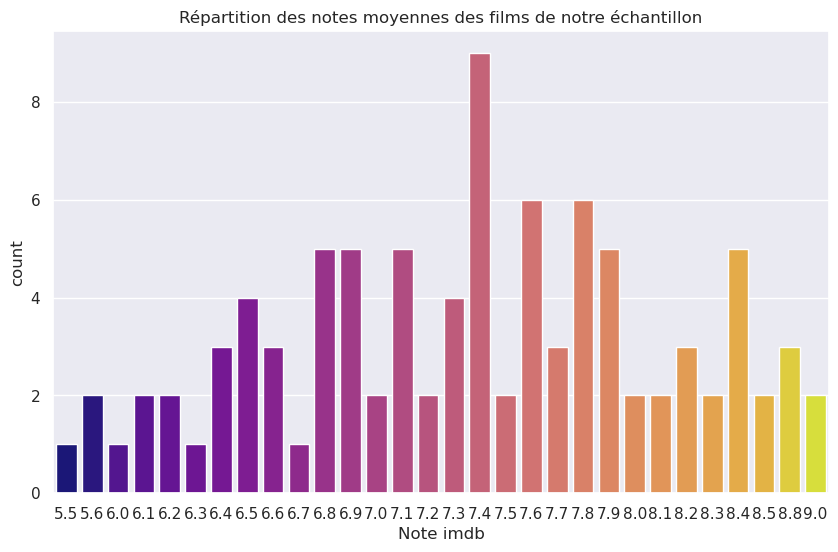

In [13]:
# Répartition de la note moyenne sur notre échantillon de 100 films
plt.figure(1, (10,6))
sns.countplot(x=df['Note imdb'], hue=df['Note imdb'], palette="plasma", legend=False)
plt.title('Répartition des notes moyennes des films de notre échantillon')
plt.show()

Les notes de notre échantillon semblent bien réparties en dans l'intervalle [5.5, 9.0], avec une forte concentration autour de 7.4, qui est la moyenne des notes de notre échantillon. 
La note minimale pour un film du top 100 sur IMDB est 5.5. La perfection ne semble pas atteignable aux yeux des spectateurs car la note maximale attribuée est de 9.0.

Nous allons maintenant nous intéresser à la distribution de ces notes.

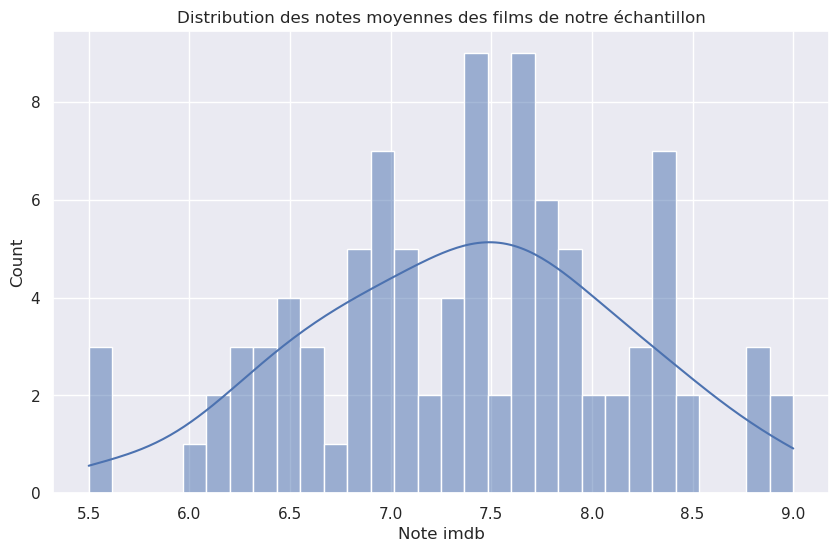

In [14]:
plt.figure(1, (10,6))
sns.histplot(x=df['Note imdb'],kde=True, bins=30)
plt.title('Distribution des notes moyennes des films de notre échantillon')
plt.show()

**Test de normalité de la distribution des notes**

Pour visualiser si nos notes suivent une distribution normale, nous allons utiliser un Q-Q plot.   

**Qu'est-ce qu'un Q-Q plot?**   
Le graphique Q-Q est une méthode graphique permettant de comparer deux distributions de probabilité en traçant leurs quantiles l'un contre l'autre. Un point sur le graphique correspond à l'un des quantiles de la deuxième distribution tracé contre le même quantile de la première distribution. Si les deux ensembles de quantiles proviennent de la même distribution, nous devrions voir les points former une ligne qui est approximativement droite.

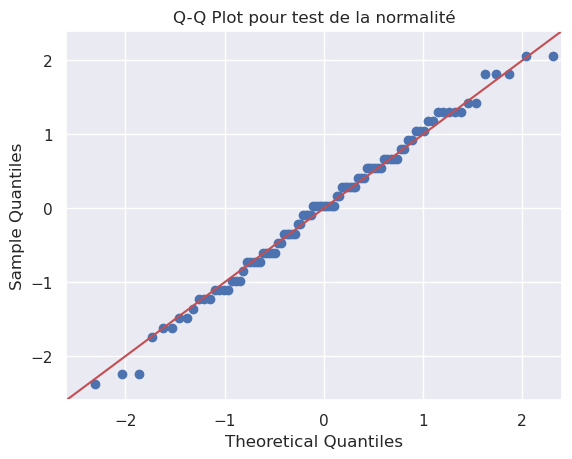

In [15]:
# Création d'un Q-Q plot
sm.qqplot((df['Note imdb']-df['Note imdb'].mean())/df['Note imdb'].std(), line='45')

# Ajout des titres et affichage du graphique
plt.title("Q-Q Plot pour test de la normalité")
plt.show()

Au vu de de notre graphique Q-Q, nous pouvons conclure que les notes suivent une distribution normale

#### **3.1.1.2** Budget et Box-Office <a class="anchor" id="section_3_1_1_2"></a>

In [16]:
# Création des variables budget et box_office
budget = df['Budget']
box_office = df['Box office']

**Statistiques du budget**

In [17]:
min_budget = df.index[df['Budget'] == df['Budget'].min()][0]
max_budget = df.index[df['Budget'] == df['Budget'].max()][0]

In [18]:
# Affichage des statistiques principales
print('=== *Statistiques Budget* ===')
print(f'Le budget moyen des 100 meilleurs films sur IMDB est de {round(budget.mean()/10**6)} millions de $')
print(f'Le film du top 100 au plus faible budget est {df.loc[min_budget,"Film"]} et a un budget de {round(budget.min()/10**6)} millions de $')
print(f'Le film du top 100 au plus haut budget est {df.loc[max_budget,"Film"]} et a un budget de {round(budget.max()/10**6)} millions de $')

=== *Statistiques Budget* ===
Le budget moyen des 100 meilleurs films sur IMDB est de 175 millions de $
Le film du top 100 au plus faible budget est Le Roi Lion (1994) et a un budget de 45 millions de $
Le film du top 100 au plus haut budget est Avengers: Endgame (2019) et a un budget de 356 millions de $


**Statistiques du Box-Office**

In [19]:
min_bo = df.index[df['Box office'] == df['Box office'].min()][0]
max_bo = df.index[df['Box office'] == df['Box office'].max()][0]

In [20]:
# Affichage des statistiques principales
print('=== *Statistiques Box office* ===')
print(f'Le revenu moyen des 100 meilleurs films sur IMDB est de {round(box_office.mean()/10**6)} millions de $')
print(f'Le film du top 100 au plus faible revenu est {df.loc[min_bo,"Film"]} et a un revenu de {round(box_office.min()/10**6)} millions de $')
print(f'Le film du top 100 au plus haut revenu est {df.loc[max_bo,"Film"]} et a un revenu de {round(box_office.max()/10**6)} millions de $')

=== *Statistiques Box office* ===
Le revenu moyen des 100 meilleurs films sur IMDB est de 1151 millions de $
Le film du top 100 au plus faible revenu est Shrek le troisième (2007) et a un revenu de 813 millions de $
Le film du top 100 au plus haut revenu est Avatar (2009) et a un revenu de 2924 millions de $


**Aperçu stylisé des statistiques ci-dessus**

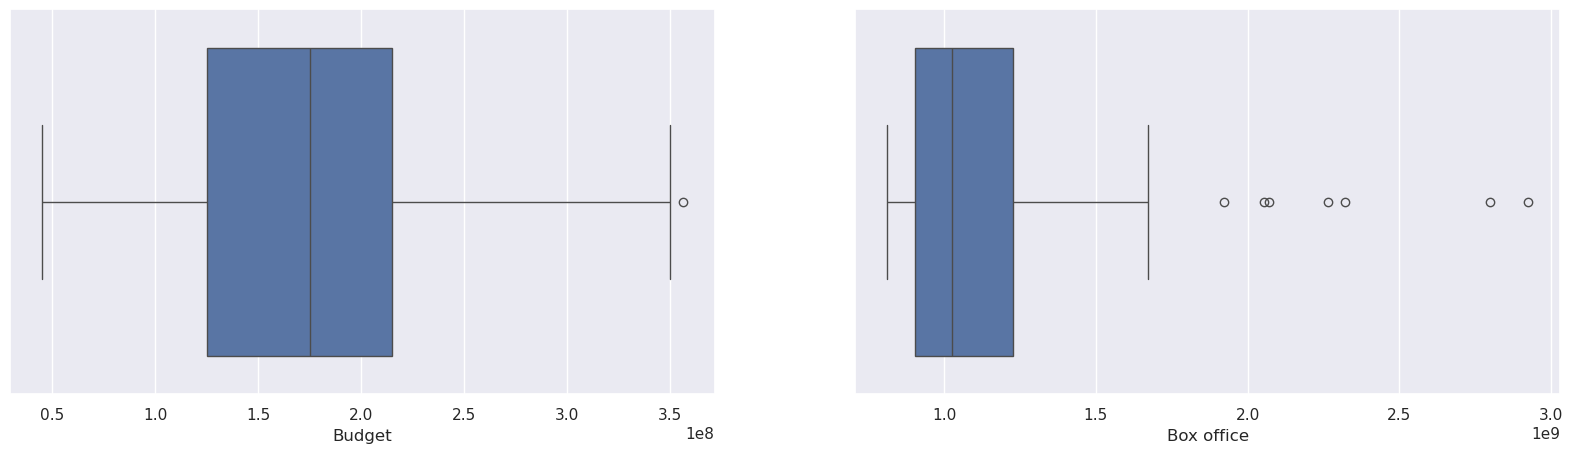

In [21]:
plt.figure(1, (20,5))

# Boxplot du budget 
plt.subplot(1,2,1)
sns.boxplot(x=budget)

# Boxplot du Box-Office
plt.subplot(1,2,2)
sns.boxplot(x=box_office)

plt.show()

La boîte à moustache du budget nous permet de visualiser les statistiques décrites précédemment. De plus, 50% des films ont un budget compris entre 1.25 et 2.1 millons de $ avec un seul outlier.    
La boîte à moustache sur le Box-office nous montre une forte variance entre les revenus générés par les différents films avec de nombreux outliers qui ont des revenus bien plus élevés que la moyenne. 

**Visualisation des distributions**   
Après avoir décrit statistiquement les variables budget et Box-Office, nous allons maintenant nous intéresser à leur distribution afin d'en extraire d'autres informations. 

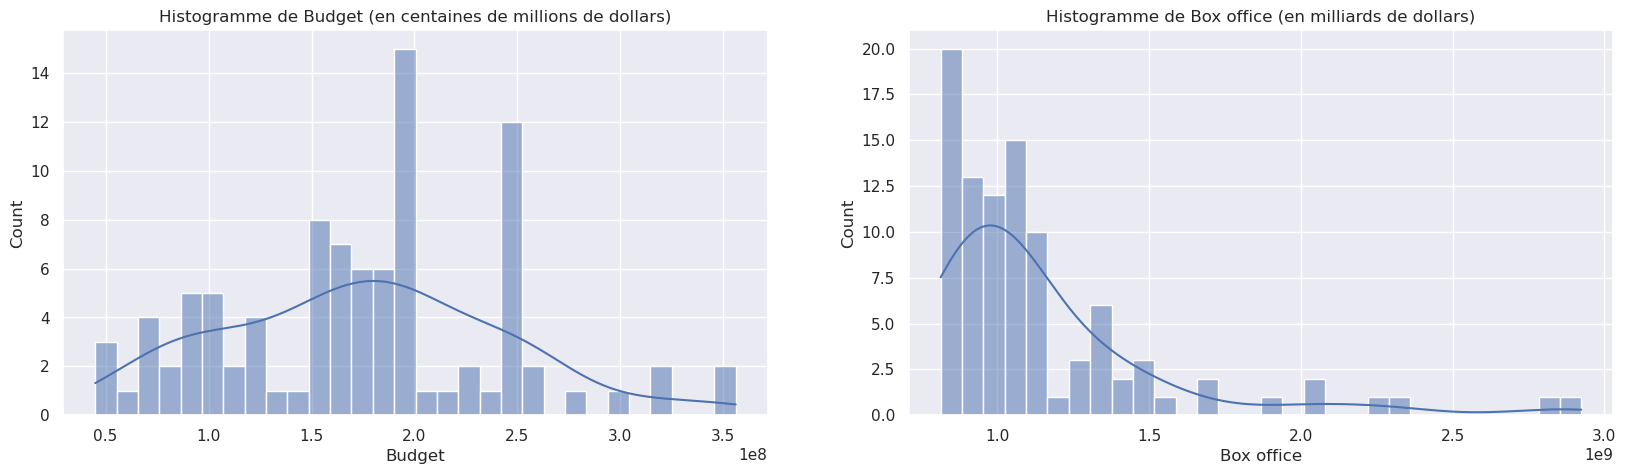

In [22]:
plt.figure(2, (20,5))

# Histogramme du Budget
plt.subplot(1,2,1)
sns.histplot(x=budget ,kde=True, bins=30)
plt.title('Histogramme de Budget (en centaines de millions de dollars)')

# Histogramme du Box-Office
plt.subplot(1,2,2)
sns.histplot(x=box_office, kde=True, bins=30)
plt.title('Histogramme de Box office (en milliards de dollars)')

plt.show()

**Log box-office**

La distribution du budget est un peu près normale. Mais la distribution du box office a un "fat tail" et a un gros "skew".

En général, les variables de revenus suivent des lois de Pareto ou log-normale. Il semble au vu du box plot et de l'histogramme que cela soit également le cas pour notre variable box_office qui est aussi en quelque sorte un revenu. Nous allons donc créer une nouvelle variable log_box_office qui est le log du Box office, puis l'analyser:

In [74]:
df['log_Box_office'] = np.log(df['Box office'])

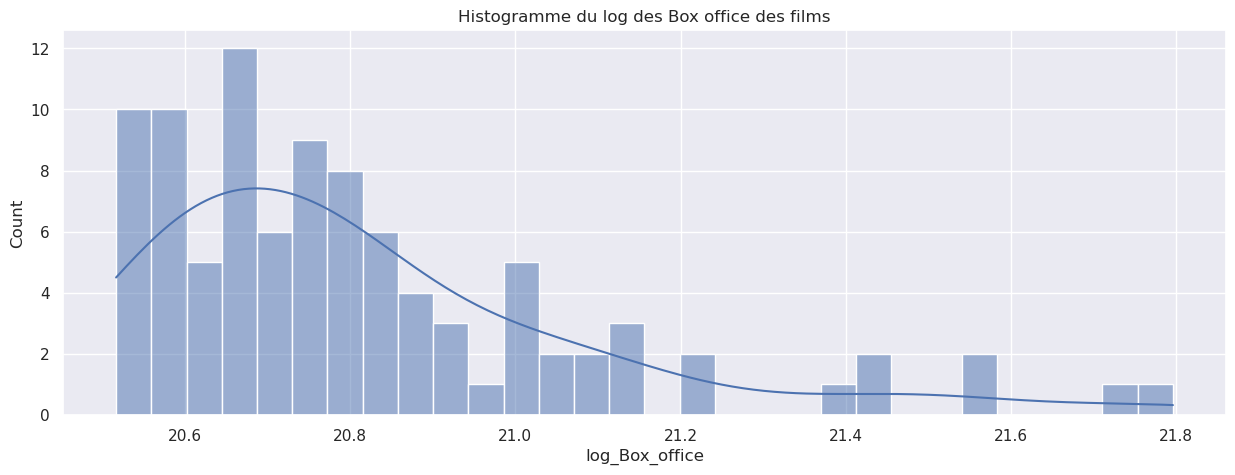

In [24]:
plt.figure(1, (15,5))
sns.histplot(x=df['log_Box_office'], kde=True, bins=30)
plt.title("Histogramme du log des Box office des films")
plt.show()

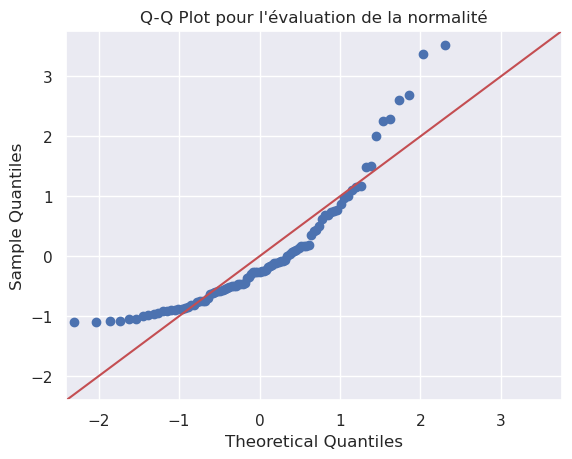

In [25]:
# Créer un Q-Q plot
sm.qqplot((df['log_Box_office']-df['log_Box_office'].mean())/df['log_Box_office'].std(), line='45')

# Ajouter des titres et afficher le plot
plt.title("Q-Q Plot pour l'évaluation de la normalité")
plt.show()

Le Log-Box-Office ne suit pas vraiment un loi normale au vu du QQ plot bien que la courbe semble s'en être rapproché au vu de l'histogramme

#### **3.1.1.3** La durée des films <a class="anchor" id="section_3_1_1_3"></a>

In [26]:
# statistiques descriptives
print('=== *Statistiques sur la Duree* ===')
print(df['duree'].describe())

=== *Statistiques sur la Duree* ===
count     95.000000
mean     134.515789
std       25.943008
min       87.000000
25%      118.000000
50%      136.000000
75%      149.500000
max      201.000000
Name: duree, dtype: float64


Sur les 95 films de notre échantillon, la durée moyenne est de 2 heures et 15 minutes. La durée de la majorité des films sortant en salle est comprise entre 1h45 et 2h15 avec une inflation ces dernières années. On peut en conclure que les meilleurs films au Box-Office sont de durée "normale" et se différencient par d'autres aspects.   

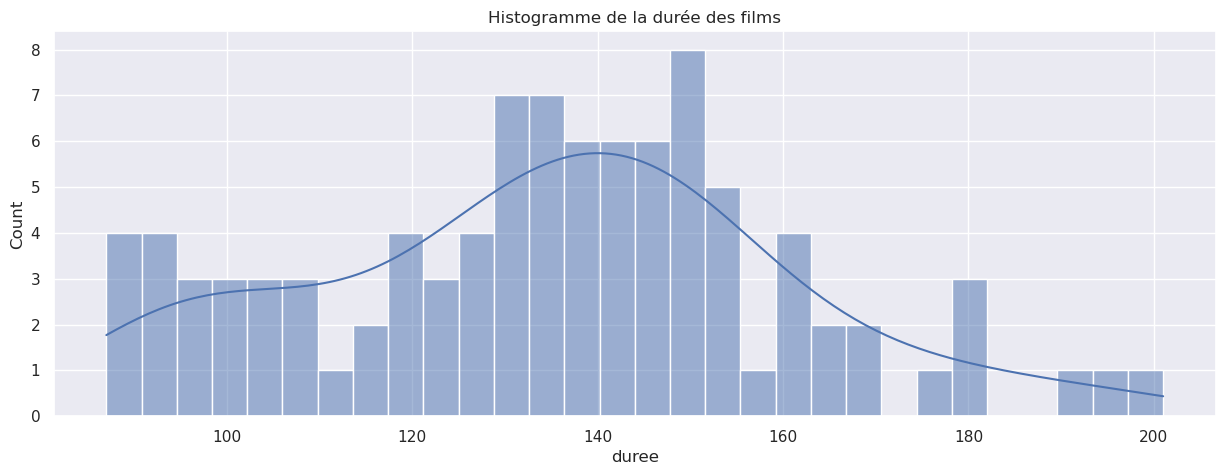

In [27]:
plt.figure(1, (15,5))
sns.histplot(x=df['duree'], kde=True, bins=30)
plt.title("Histogramme de la durée des films")
plt.show()

A la vue de cet histogramme, on peut dresser une typologie de film divisée en 3 catégories: 
+ Les films courts avec une durée inférieure à 2H
+ Les films standards d'une durée de 2H jusqu'à 2H30
+ et enfin les films longs, moins nombreux, d'une durée supérieur à 2H30

### **3.1.2** Variables textuelles  <a class="anchor" id="section_3_1_2"></a>
Après l'étude statistique des variables numériques, nous allons maintenant analyser les commentaires d'un point de vue statistique

#### **3.1.2.1** Autour de la distribution des scores de polarité moyens <a class="anchor" id="section_3_1_2_1"></a>

**Distribution de la polarité moyenne des sentiments par film:**
+ **Avec Text Blob**

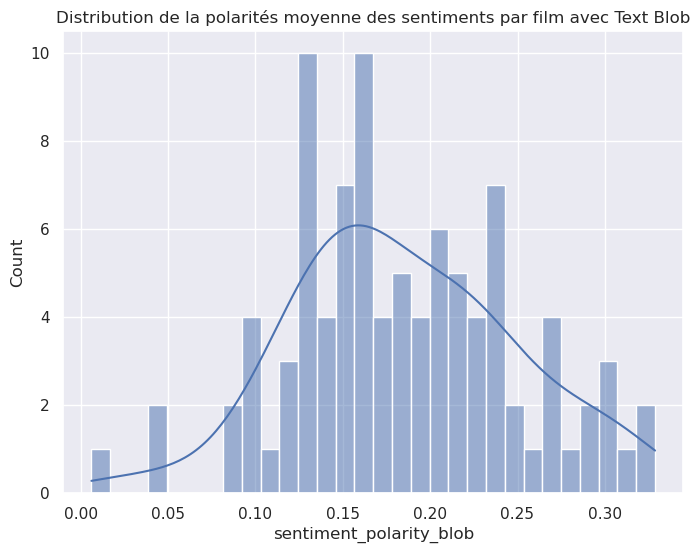

In [28]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['sentiment_polarity_blob'],kde=True, bins=30)
plt.title('Distribution de la polarités moyenne des sentiments par film avec Text Blob')
plt.show()

* **Avec NLTK**

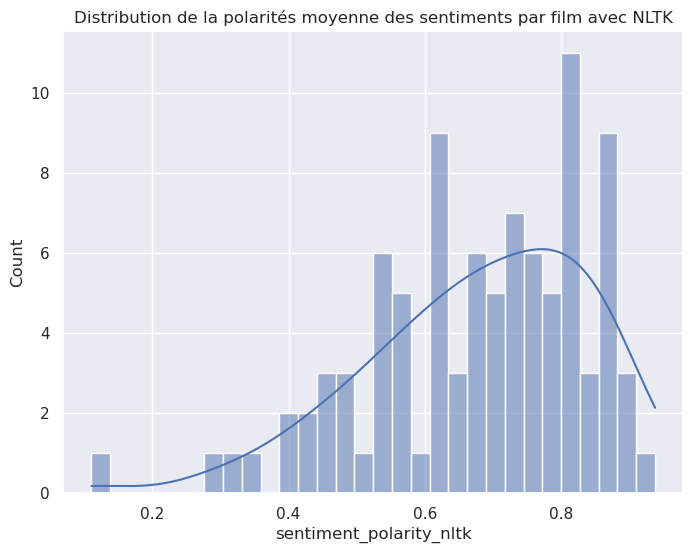

In [29]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['sentiment_polarity_nltk'],kde=True, bins=30)
plt.title('Distribution de la polarités moyenne des sentiments par film avec NLTK')
plt.show()

En comparant les deux histogrammes, on remarque que les distributions sont bien différentes selon le modèle de NLP utilisé. En effet, la distribution des polarité avec Text_blob a une très faible variance et est très concentrée entre 0.10 et 0.25. En revanche, les polarités avec NLTK semblent être normalement distribuées avec une présence de skewness prononcée. 

Après investigation, il semblerait que Text Blob soit construit sur NLTK et spécialisé dans l'analyse des sentiments. De plus, au vu des histogrammes, la distribution de la variable évaluée avec Text Blob se rapproche plus d'une normale. Ce qui est préférable pour vérifier certaines hypothèses et puisque les notes aussi suivent une normale. Nous le vérifions à l'aide d'un QQ-plot:

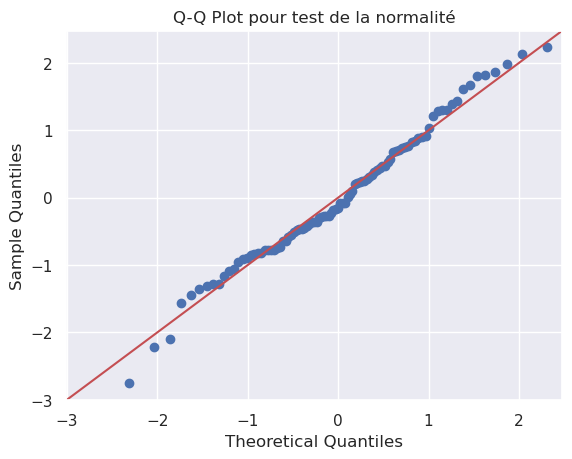

In [32]:
#Création d'un Q-Q plot
sm.qqplot((df['sentiment_polarity_blob']-df['sentiment_polarity_blob'].mean())/df['sentiment_polarity_blob'].std(), line='45')

# Ajout des titres et affichage du graphique
plt.title("Q-Q Plot pour test de la normalité")
plt.show()

Les scores de polarité évalués avec TextBlob suivent effectivement une loi normale

Nous allons donc garder uniquement les variables évaluées avec Text Blob, Elles sont de toute façon très corrélées:

In [34]:
print(df['sentiment_polarity_nltk'].corr(df['sentiment_polarity_blob']))

0.7417632126035838


In [75]:
# Supprimons les colonnes 'sentiment_polarity_nltk' et 'var_score_nltk'
df = df.drop(['sentiment_polarity_nltk','var_score_nltk'], axis=1)

#### **3.1.2.2** Distribution de la variance des scores des sentiments <a class="anchor" id="section_3_1_2_2"></a>

Nous rappelons que la variable "sentiment_polarity_blob" a été évaluée en i) attribuant un score de polarité à chaque commentaire de notre dataset ii) faisant la moyenne de ces scores pour chaque film. <br> 
La variable "var_score_blob" quant à elle, a été évaluée en prenant la variance des scores de polarité pour chaque film. Cela nous permet d'évaluer le "clivage" d'un film. C'est-à-dire évaluer si tout le monde avait un peu près le même avis, le même score de polarité, ou alors s'il avait des spectateurs avec un score très favorable et d'autres avec un score très défavorable. En effet, cela n'est pas capté par notre variable sentiment polarity puisqu'il s'agit d'une moyenne.

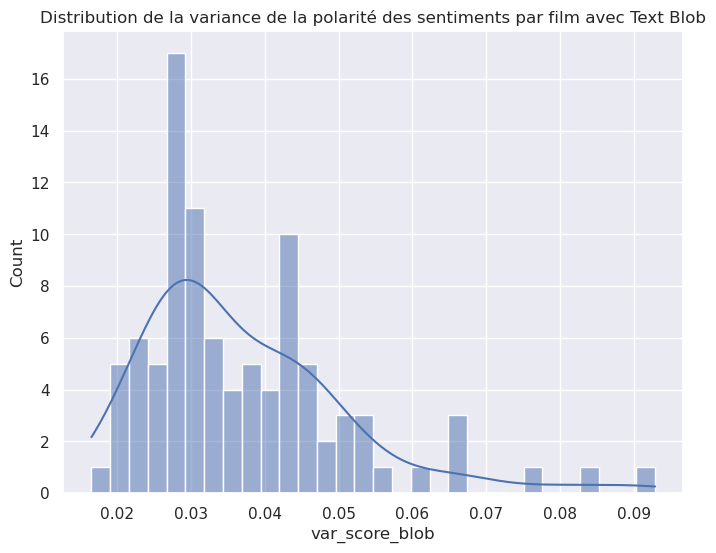

In [36]:
# Affichage de l'histogramme 
plt.figure(1, (8,6))
sns.histplot(df['var_score_blob'],kde=True, bins=30)
plt.title('Distribution de la variance de la polarité des sentiments par film avec Text Blob')
plt.show()

On observe que la plupart des films ont à peu près une faible variance des scores. Il y a cependant des films avec de grosses disparités dans les scores (4-5 films avec une variance des scores supérieure à 0.06). Ces films sont:

In [37]:
display(df[df['var_score_blob']>0.06])

,Film,var_score_blob,duree,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office,log_Box_office
3,Aquaman (2018),0.092883,143,0.006167,6.8,2018.0,160000000.0,1.157347e+09,20.869397
8,Avengers: Endgame (2019),0.077276,181,0.203876,8.4,2019.0,356000000.0,2.799439e+09,21.752685
9,Avengers: Infinity War (2018),0.066110,149,0.160883,8.4,2018.0,321000000.0,2.052415e+09,21.442283
33,Joker (2019),0.067149,122,0.179823,8.4,2019.0,55000000.0,1.078958e+09,20.799262
40,La Reine des Neiges 2 (2019),0.085040,103,0.102049,6.8,2019.0,150000000.0,1.453683e+09,21.097367
73,Spider-Man: No Way Home (2021),0.064976,148,0.200781,8.2,2021.0,200000000.0,1.921847e+09,21.376553
91,Venom (2018),0.060161,112,0.199054,6.6,2018.0,100000000.0,8.560852e+08,20.567880


### **3.1.3** Interactions entre les variables <a class="anchor" id="section_3_1_3"></a>

Nous allons désormais étudier en bref l'interaction qu'ont nos variables entre elles, en nous concentrant surtout sur nos variables de score de polarité:

#### **3.1.3.1** Pairgrid <a class="anchor" id="section_3_1_3_1"></a>

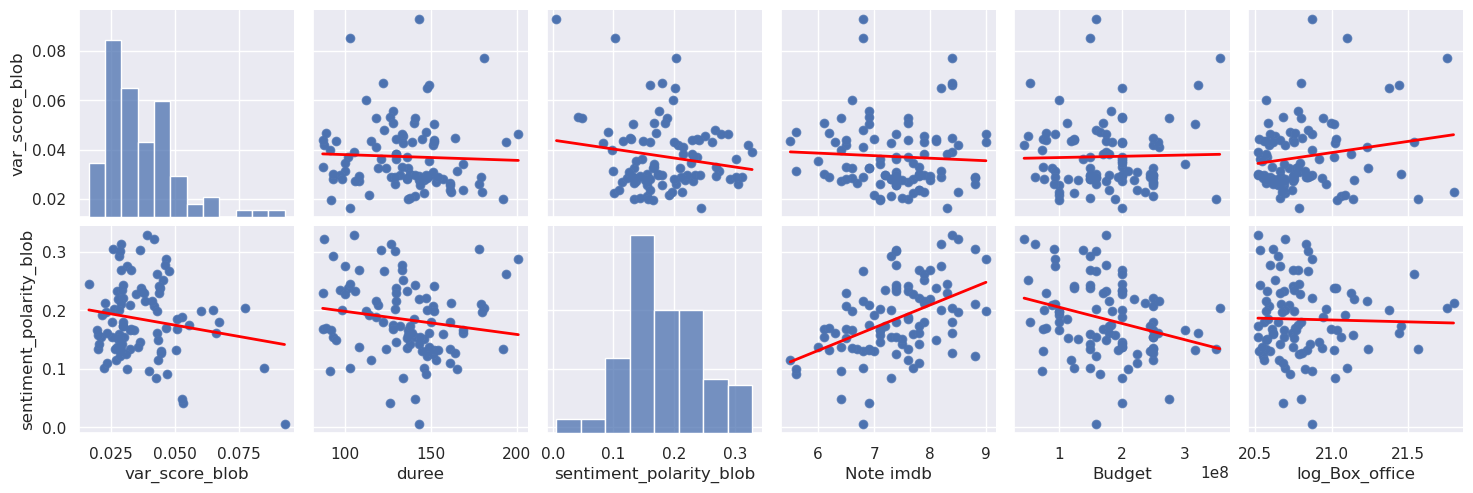

In [38]:
# Variables en ordonnée du pairplot
y_vars = ['var_score_blob', 'sentiment_polarity_blob']

# Initialisation du pairplot
g = sns.pairplot(df.drop(['Annee', 'Box office'], axis = 1), y_vars=y_vars)

# Ajoute des scatter plots sur la diagonale
g.map_diag(sns.scatterplot)

# Ajoute des scatter plots et des lignes de régression en dehors de la diagonale
g.map_offdiag(sns.regplot, line_kws={'color': 'red', 'linewidth': 2}, ci=None)

# Affiche le graphique
plt.show()

Ce graphique est assez lourd à interpréter.<br>
Tout d'abord concentrons nous sur la variable sentiment_polarity_blob:
+ Elle semble être légérement corrélée négativement avec les variables "var_score_blob", "duree" et "budget"
+ indépendante du log du box office
+ corrélée positivement avec la variable de la note du film

Quant à la variable var_score_blob:
+ Elle semble être indépendante de la durée, de la note et du budget
+ très légérement corrélée négativement avec la variable sentiment_polarity
+ très légérement corrélée positivement avec la variable log_box_office

Globalement, ce graphique montre des résultats plutôt décévants où les variables ne semblent pas vraiment liées entre elles.

### **3.1.4** Scatterplot

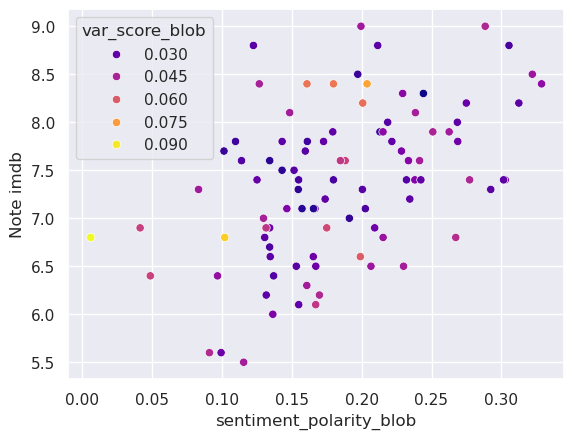

In [39]:
sns.scatterplot(x='sentiment_polarity_blob', y='Note imdb', hue='var_score_blob', data=df, legend='brief', palette='plasma')
plt.show()

Nous observons que la variance des scores semble indépendante de la note et du score de sentiment moyen de chaque film, ce qui n'était pas forcément une évidence.

## **3.2.** Etude Econometrique <a class="anchor" id="section_3_2"></a>

Nous allons maintenant pouvoir tenter de répondre à certaines questions via une analyse économétrique en prenant compte la partie précédente.

### **3.2.1** Matrice de corrélation <a class="anchor" id="section_3_2_1"></a>

Faison apparaître la matrice de corrélation de nos variables. Cela nous servira dans nos choix de sélection:

In [40]:
# matrice de corrélation
df.drop('Film', axis=1).corr()

,var_score_blob,duree,sentiment_polarity_blob,Note imdb,Annee,Budget,Box office,log_Box_office
var_score_blob,1.000000,-0.042843,-0.167612,-0.057659,0.205623,0.024955,0.174942,0.179037
duree,-0.042843,1.000000,-0.158302,0.282306,-0.172529,0.403632,0.272298,0.231160
sentiment_polarity_blob,-0.167612,-0.158302,1.000000,0.473369,-0.259864,-0.293974,-0.005480,-0.027587
Note imdb,-0.057659,0.282306,0.473369,1.000000,-0.219841,-0.055634,0.174280,0.152712
Annee,0.205623,-0.172529,-0.259864,-0.219841,1.000000,0.288947,0.155760,0.189146
Budget,0.024955,0.403632,-0.293974,-0.055634,0.288947,1.000000,0.420877,0.401318
Box office,0.174942,0.272298,-0.005480,0.174280,0.155760,0.420877,1.000000,0.981009
log_Box_office,0.179037,0.231160,-0.027587,0.152712,0.189146,0.401318,0.981009,1.000000


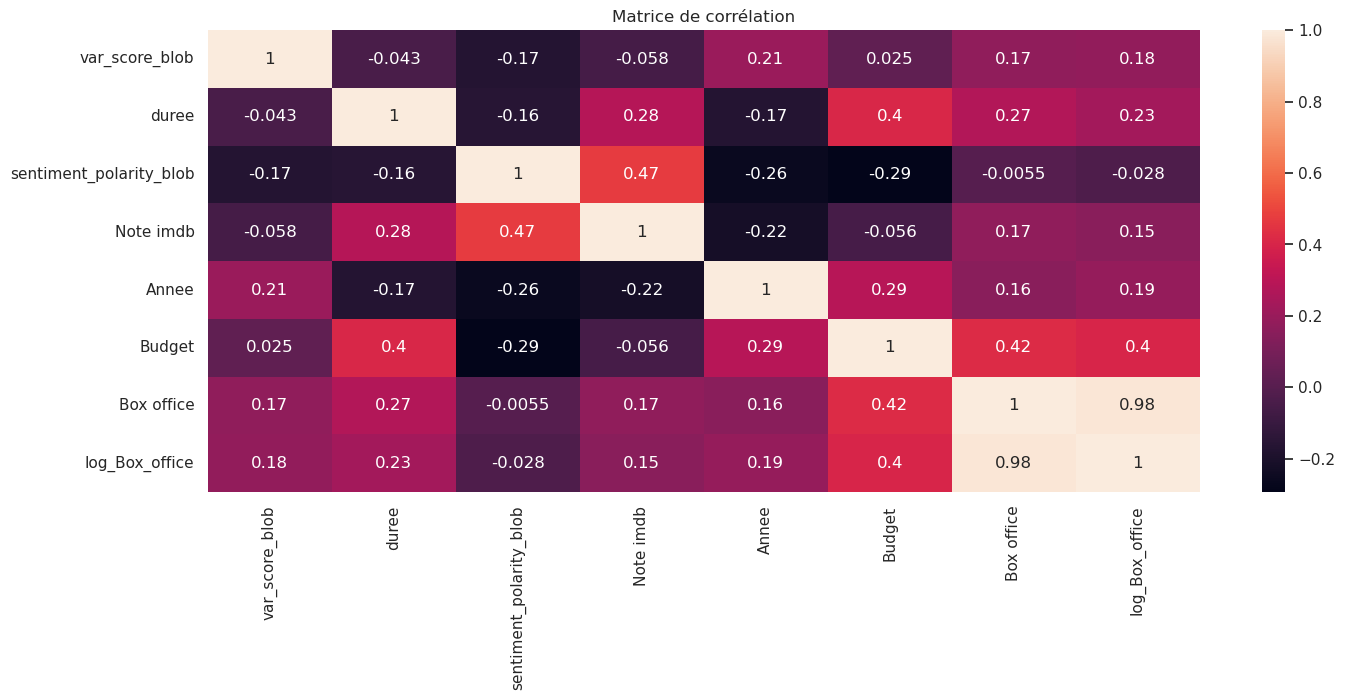

In [42]:
plt.figure(figsize=(16, 6))

# Création de la heatmap
heatmap = sns.heatmap(df.drop('Film', axis=1).corr(), annot=True)
heatmap.set_title('Matrice de corrélation')
plt.show()

Comme on pouvait s'en douter, on remarque une forte corrélation entre le budget d'un film et ses revenus au Box-Office, avec une corrélation positive de 0.42.   
De plus, on s'aperçoit que la corrélation entre le budget et la durée du film est elle aussi de l'ordre de 0.4, ce qui parait logique car plus une film est long plus il est coûteux. 

Nous renormalisons la variable 'sentiment_polarity_blob' pour avoir des résultats mieux interprétables:

In [119]:
scaler = StandardScaler()
df['sentiment_polarity_scaled'] = scaler.fit_transform(df['sentiment_polarity_blob'].values.reshape(-1, 1))
print(df['sentiment_polarity_scaled'].min(), df['sentiment_polarity_scaled'].max())

-2.7706899152232802 2.2403724669735565


Le range des scores est désormais entre -2.7 pour un film avec des commentaires très négatifs et 2.3 pour un film avec des commentaires très positifs

### **3.2.2** Les scores calculés par l'algorithme de Textblob restent-t-ils cohérents avec la note imbd des films ? <a class="anchor" id="section_3_2_2"></a>

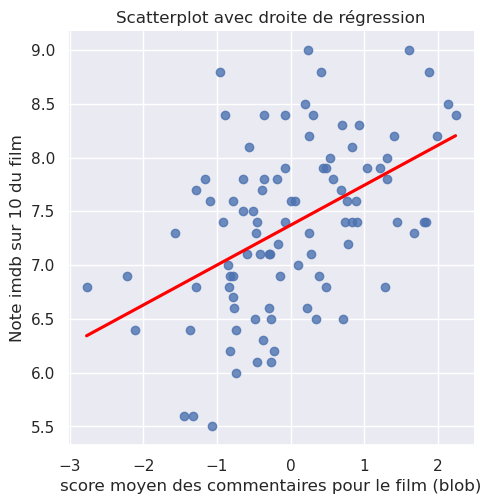

In [45]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_scaled', y='Note imdb', data=df, line_kws={'color': 'red'}, ci=None)
# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (blob)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

Le graphique nous montre que les scores semblent "fiter" avec les notes dans la globalité, mais il existe tout de même des disparités assez frappantes: Par lecture graphique, certains films ont le même score de polarité moyen alors qu'ils ont une note différente de 4 points sur 10.

In [46]:
#ajout de la constante
df = sm.add_constant(df)

In [47]:
# régression de la note note imdb sur le score "sentiment_polarity_scaled"
model_1 = sm.OLS(df['Note imdb'], df[['const', 'sentiment_polarity_scaled']]).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              Note imdb   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     26.86
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           1.27e-06
Time:                        21:50:53   Log-Likelihood:                -99.664
No. Observations:                  95   AIC:                             203.3
Df Residuals:                      93   BIC:                             208.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Le coefficient estimé de la variable "sentiment_polarity_blob" est difficilement interprétable (à part qu'il est positif) puisque l'échelle est arbitraire. Cependant, nous pouvons remarquer que le $R^{2}$ est de 0.2. Ce qui signifie que les scores de polarité explique tout de même 20% de la variance des notes. Le coefficient estimé a une p-value proche de zero. Ce qui signifie que les notes et les scores ont une corrélation statistiquement significative.

La réponse a notre question est donc plutôt oui dans la globabilité, bien qu'il existe toutefois de grosses disparités.

### **3.2.3** Est-ce que plus un film est long, plus les commentaires seront négatifs ? <a class="anchor" id="section_3_2_3"></a>

- **Regression simple**

In [ ]:
# régression de "sentiment_polarity_scaled" sur la durée
model_2 = sm.OLS(df['sentiment_polarity_scaled'], df[['const', 'duree']]).fit()
print(model_2.summary())

Le coefficient estimé de durée n'est ni significatif économiquement ni significatif satistiquement (p-value égal à 0.12). La polarité des commentaires semblent indépendantes de la durée du film.

- **Regression multiple**

Il peut être interessant de faire une regression multiple pour controler certains effets et retirer des biais de variables omises.<br>  -Par exemple, en observant la matrice de corrélation, nous pouvons voir que la durée est corrélée avec le budget (à 0.4) qui lui même est corrélé avec notre score de polarité (à -0.3). Le budget est donc une variable omise que l'on doit inclure.<br>
-Il peut également être interessant d'integrer l'année pour les mêmes raisons.<br>
-Inclure la note imbd n'a pas  vraiment de sens puisque cette variable explique la même chose que le score du sentiment mais de façon différente. <br>
-Le Box-office est très peu corrélé avec le score de polarité. Il est inutile de l'inclure ici.

In [54]:
# régression de "sentiment_polarity_scaled" sur la durée et le budget
model_3 = sm.OLS(df['sentiment_polarity_scaled'], df[['const', 'duree', 'Budget']]).fit()
print(model_3.summary())

                                OLS Regression Results                               
Dep. Variable:     sentiment_polarity_scaled   R-squared:                       0.088
Model:                                   OLS   Adj. R-squared:                  0.068
Method:                        Least Squares   F-statistic:                     4.455
Date:                       Fri, 29 Dec 2023   Prob (F-statistic):             0.0142
Time:                               21:58:57   Log-Likelihood:                -130.41
No. Observations:                         95   AIC:                             266.8
Df Residuals:                             92   BIC:                             274.5
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Nous observons que le coefficient de duree reste très faible et non significatif statistiquement (p-value égal à 0.664), même en controllant le budget.

La réponse à notre question semble être donc non, en tout cas nous échouons à rejetter l'hypothèse que la durée à un effet sur le score de polarité d'un film.

### **3.2.4** Le budget d'un film a-t-il un effet sur le score de polarité? Et pour l'année de sortie du film? <a class="anchor" id="section_3_2_4"></a>

Nous allons procéder directement à une regression multiple du score de polarité sur l'année et le budget car ces variables sont corrélées les unes aux autres. En effet, les films recents ont bien sûr un budget plus élévé.

In [53]:
# régression de "sentiment_polarity_scaled" sur l'année et le budget
model_4 = sm.OLS(df['sentiment_polarity_scaled'], df[['const', 'Annee', 'Budget']]).fit()
print(model_4.summary())

                                OLS Regression Results                               
Dep. Variable:     sentiment_polarity_scaled   R-squared:                       0.120
Model:                                   OLS   Adj. R-squared:                  0.101
Method:                        Least Squares   F-statistic:                     6.261
Date:                       Fri, 29 Dec 2023   Prob (F-statistic):            0.00282
Time:                               21:58:40   Log-Likelihood:                -128.74
No. Observations:                         95   AIC:                             263.5
Df Residuals:                             92   BIC:                             271.1
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Il semblerait que les films récents ont obtiennent de moins bon score polarité, à budget fixé, bien que cela ne soit pas très statitistiquement signicatif (p-value à 6.5%), ni économiquement (coefficient très petit).<br>
Nous obtenons également que les films à gros budget tendent à avoir de moins bon score de polarité, à date de sortie fixée. Le coefficient estimé du budget est significatif statistiquement au seuil de 2.2% mais il semble assez faible: Le budget étant de l'ordre de 1e8, le coefficient signifie qu'à date de sortie fixée, une augmentation de 100 millions (1e8) du budget conduit à une légère baisse du score de polarité (normalisé) de 0.3.

Au vu des résultats, il ne semble pas qu'il y ait une relation claire entre l'année de sortie ou le budget avec le score de polarité, ou alors les effets sont très légérements négatifs. C'est-à-dire que les films recents et à gros budget sont un peu moins bien commentés, ce qui n'est pas vraiment absurde.

### **3.2.5** Avons-nous des résultats différents en considérant cette fois comme variable à expliquer directement les notes? <a class="anchor" id="section_3_2_5"></a>

In [52]:
# régression des notes sur l'année, le budget et la durée du film
model_5 = sm.OLS(df['Note imdb'], df[['const', 'Annee', 'Budget', 'duree']]).fit()
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:              Note imdb   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     4.370
Date:                Fri, 29 Dec 2023   Prob (F-statistic):            0.00638
Time:                        21:58:30   Log-Likelihood:                -105.32
No. Observations:                  95   AIC:                             218.6
Df Residuals:                      91   BIC:                             228.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.7515     24.695      1.367      0.1

Les résultats sont cette fois vraiment interprétable au niveau de la valuer des coefficients (les notes vont de 0 à 10). Cependant, les résultats restent du même acabit que précédemment, à savoir que les coefficients sont ou bien ridiculement faibles ou bien non significatifs statistiquement ou bien les deux.

Cela peut nous rassurer dans la mesure où notre manque de résultat avec les scores de polarité pourrait s'expliquer moins par la qualité de variable elle-même que de la qualité de notre dataset (choix des variables et nombres d'observations). Les relations que nous essayons d'étayer ne sont pas vraiment évidentes voire peut-être inexistantes.

### **3.2.6** Autour de la variable de variance des scores de polarité "var_score_blob" <a class="anchor" id="section_3_2_6"></a>

Au vu du Pairgrid 1.3.1, et de la matrice de corrélation, la variable "var_score_blob" censée capturer le clivage des avis autour d'un film semble complétement indépendante du reste des variables. Ainsi, toute modélisation autour de cette variable semble vaine et inutile.

# 4 - Modélisation <a class="anchor" id="chapter4"></a>

Dans cette partie, nous allons élaborer un modèle permettant la prédiction de la note d'un film à partir de son budget, ses entrées au box office, sa durée et le score d'analyse de sentiment obtenu grâce à BLOB. Au vu des données que nous avons et du nombre d'observations également, le type de modèle qui correspondrait le mieux à cette problématique est une régression linéaire multiple. Pour ce faire, nous allons d'abord commencer par le préprocessing des données, la création d'un train set et d'un test set, puis nous allons entraîner le modèle, pour finalement l'évaluer.

## **4.1** Pre-Processing <a class="anchor" id="section_4_1"></a>

Il faut d'abord commencer par préparer notre jeu de données pour qu'il soit possible de réaliser un modèle de prédiction. Pour cela, on encode les variables catégorielles et on normalise les variables quantitatives.

Comme nous l'avons vu dans la partie précédente, on peut classifier les films de par leur durée en : film court (moins de 2h), film moyen (entre 2h et 2h30) et film long (plus de 2h30)

In [90]:
# Fonction permettant de déterminer le type de film en fonction de sa durée
def longueur(duree):
    if duree < 120:
        return 'court'
    elif (120 <= duree) &  (duree <= 150):
        return 'moyen'
    else:
        return 'long'

In [130]:
# Utilise .loc pour éviter la mise en garde SettingWithCopyWarning
df['duree_cat'] = df['duree'].apply(longueur)

On sélectionne les variables qui nous interessent:

In [131]:
movies = df[['Note imdb', 'Budget', 'Box office', 'duree', 'duree_cat', 'sentiment_polarity_scaled']]
movies.head()

,Note imdb,Budget,Box office,duree,duree_cat,sentiment_polarity_scaled
0,6.8,245000000.0,8.807053e+08,148,moyen,-0.836489
1,6.9,183000000.0,1.054304e+09,128,moyen,-0.147581
2,6.4,200000000.0,1.025468e+09,108,court,-0.737470
3,6.8,160000000.0,1.157347e+09,143,moyen,-2.770690
4,7.9,237000000.0,2.923706e+09,162,long,0.443987


Commençons par encoder la variable durée_cat, catégorielle, avec un encodage one-hot.

In [132]:
encoded_col = pd.get_dummies(movies['duree_cat'], prefix = 'duree')
movies = pd.concat([movies,encoded_col], axis=1)
movies.head()

,Note imdb,Budget,Box office,duree,duree_cat,sentiment_polarity_scaled,duree_court,duree_long,duree_moyen
0,6.8,245000000.0,8.807053e+08,148,moyen,-0.836489,False,False,True
1,6.9,183000000.0,1.054304e+09,128,moyen,-0.147581,False,False,True
2,6.4,200000000.0,1.025468e+09,108,court,-0.737470,True,False,False
3,6.8,160000000.0,1.157347e+09,143,moyen,-2.770690,False,False,True
4,7.9,237000000.0,2.923706e+09,162,long,0.443987,False,True,False


A présent, supprimons les colonnes que nous n'utiliserons pas par la suite, à savoir: duree_long (dépend linéairement de duree_court et de duree_moyen) et la colonne duree.

In [133]:
movies.drop(['duree', 'duree_cat', 'duree_long'], axis=1, inplace=True)
movies.head()

,Note imdb,Budget,Box office,sentiment_polarity_scaled,duree_court,duree_moyen
0,6.8,245000000.0,8.807053e+08,-0.836489,False,True
1,6.9,183000000.0,1.054304e+09,-0.147581,False,True
2,6.4,200000000.0,1.025468e+09,-0.737470,True,False
3,6.8,160000000.0,1.157347e+09,-2.770690,False,True
4,7.9,237000000.0,2.923706e+09,0.443987,False,False


Avant de passer à la standardisation des variables quantitatives, divisons d'abord notre DataFrame en un train set servant à entraîner notre modèle et un test set pur l'évaluer. On commencera d'abord par un test set correspondant à 25% des observations.

In [149]:
columns = ['Budget', 'Box office', 'duree_court', 'duree_moyen', 'sentiment_polarity_scaled']
X_train, X_test, y_train, y_test = train_test_split(movies[columns], movies['Note imdb'], test_size=0.25, random_state=1234)

Maintenant, procédons à la standardisation des variables quantitatives. Pour cela, nous allons entraîner le Standardscaler de sklearn avec le train set et le transformer, puis nous allons tnansformer le test set avec ce même scaler.

In [150]:
quantitative_data = X_train.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
standardized_quantitative = scaler.fit_transform(quantitative_data)

cols = list(quantitative_data.columns)
X_train[cols] = standardized_quantitative
X_test[cols] = scaler.transform(X_test[cols])

## **4.2** Modèle de régression multiple <a class="anchor" id="section_4_2"></a>

Finalement, nous pouvons entraîner un modèle de régression linéaire et l'évaluer avec notre test set.

La Mean Squarred Error est de : 0.4479645284779843
Le score R2 de la régression est de : 0.3468317932277265


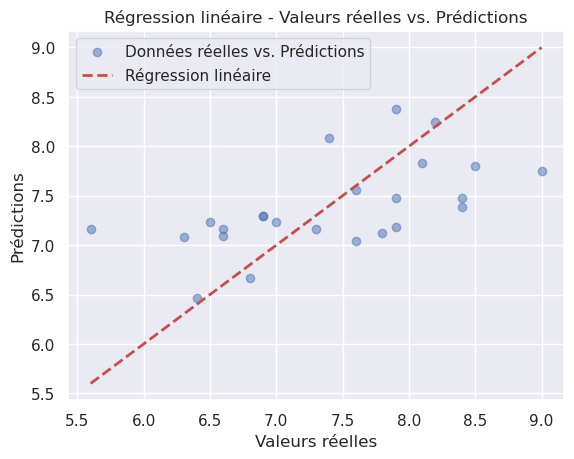

Une MSE de 0.45 suggère qu'une partie de la variance de la note des films n'est pas expliquée par le modèle. Le R2 de 0.35 indique que le modèle explique 34.7% de la variance des notes.


In [151]:
modele = LinearRegression()
modele.fit(X_train, y_train)

predictions = modele.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
coefficients = modele.coef_
intercept = modele.intercept_

print("La Mean Squarred Error est de :", mse)
print("Le score R2 de la régression est de :", r2)


plt.scatter(y_test, predictions, alpha=0.5, label='Données réelles vs. Prédictions')


plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Régression linéaire', linewidth=2)

plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Régression linéaire - Valeurs réelles vs. Prédictions')
plt.legend()
plt.grid(True)
plt.show()

print(f"Une MSE de {mse:3.2f} suggère qu'une partie de la variance de la note des films n'est pas expliquée par le modèle. Le R2 de {r2:3.2f} indique que le modèle explique {r2*100:3.1f}% de la variance des notes.")

In [152]:
coeff_df = pd.DataFrame(coefficients, X_train.columns, columns = ['Coeffcients'])
coeff_df

,Coeffcients
Budget,-0.074391
Box office,0.121125
duree_court,-0.691594
duree_moyen,-0.317293
sentiment_polarity_scaled,0.388810


Grâce à cette table présentant les coefficients de chaque variable, nous pouvons en déduire que:

+ Un box office plus élevé est associé à une légère augmentation de la note du film.
+ Les films plus courts ont tendance à avoir une note bien plus basse que les films longs. De même, avec les films de durée moyenne, mais la différence est moins grande.
+ Un score d'analyse de sentiment plus élevé est fortement associé à une note de film plus élevée.

Cependant, les coefficients relativement faibles pourraient indiquer que d'autres variables non incluses dans ce modèle pourraient avoir une influence significative sur la note du film. Il pourrait être bénéfique d'explorer d'autres caractéristiques potentiellement pertinentes pour améliorer la capacité prédictive du modèle.

En ce qui concerne notre problématique, le score d'analyse de sentiment n'expliquerait pas complètment la note du film. On pourrait dire que certains aspects dans la notation des films sont omis dans les commentaires en général.

Au vu des résultats obtenus dans la partie d'analyse économétrique, essayons d'inclure dans le modèle le log de la variable box office.

La Mean Squarred Error est de : 0.531733464742889
Le score R2 de la régression est de : 0.17015694241924817


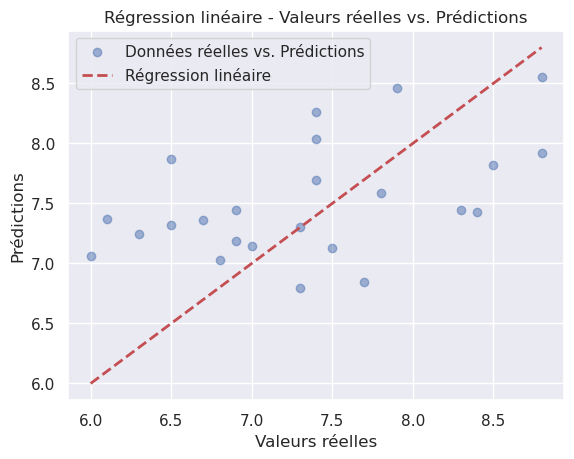

In [155]:
movies['log_box_office'] = movies['Box office'].apply(np.log)
columns =  ['Budget', 'log_box_office', 'duree_court', 'duree_moyen', 'sentiment_polarity_scaled']
X_train, X_test, y_train, y_test = train_test_split(movies[columns], movies['Note imdb'], test_size=0.25)

quantitative_data = X_train.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
standardized_quantitative = scaler.fit_transform(quantitative_data)

cols = list(quantitative_data.columns)
X_train[cols] = standardized_quantitative
X_test[cols] = scaler.transform(X_test[cols])

modele = LinearRegression()
modele.fit(X_train, y_train)


predictions = modele.predict(X_test)


mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
coefficients = modele.coef_
intercept = modele.intercept_

print("La Mean Squarred Error est de :", mse)
print("Le score R2 de la régression est de :", r2)


plt.scatter(y_test, predictions, alpha=0.5, label='Données réelles vs. Prédictions')


plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Régression linéaire', linewidth=2)

plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Régression linéaire - Valeurs réelles vs. Prédictions')
plt.legend()
plt.grid(True)
plt.show()




En utilisant le log du box office, les résultats sont légérement meilleurs. 

## **4.3** Amélioration du modèle <a class="anchor" id="section_4_3"></a>

Essayons maintenant d'améliorer le modèle. En effet, le problème du manque de résultat peut provenir du train set que nous avons choisi. C'est pour cela qu'avec une cross-validation nous pouvons évaluer les performances de ce dernier avec plusieurs partitions d'entraînement.

In [156]:
X, y = movies[columns], movies['Note imdb']

model = LinearRegression()

# Effectuer une validation croisée avec 5 plis (5-fold cross-validation)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # Utilisation du R² comme métrique de score

# Affichage des scores de chaque pli et le score moyen
print("Scores de chaque pli :", scores)
print(f"Score moyen de la validation croisée : {np.mean(scores):.4f}")

Scores de chaque pli : [ 0.16769687 -0.33715751  0.35547141  0.12002812  0.18530527]
Score moyen de la validation croisée : 0.0983


Pour le deuxième pli, nous avons obtenu un R2 négatif indiquant que la partition choisie a donné naissance à un mauvais modèle de prédiction. De plus, tous les scores de R2 obtenus sont inférieurs au premier R2 obtenu. La méthode de cross-validation n'a pas permis d'améliorer le modèle. Il se pourrait qu'il faut nécessairement plus de variables pour avoir un bon modèle de prédiction.

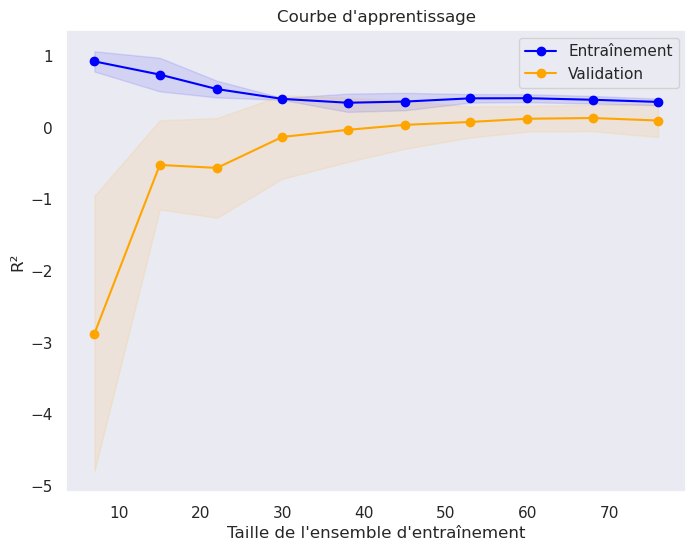

In [157]:
model = LinearRegression()

# Calculez les courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculez les moyennes et écart-types des scores d'entraînement et de test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="orange")
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Entraînement")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Validation")

plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("R²")
plt.legend(loc="best")
plt.grid()
plt.show()


On peut déduire des courbes d'apprentissage qu'au vu de la stabilité des deux courbes d'entrainement et d'évalution, le modèle n'a plus besoin de données supplémentaires afin de faire une prédiction, même si elles convergent vers des R2 très faibles. Le problème s'agirait donc en effet d'un manque de variables expliquant le reste de la variance des notes des films.

<h1> Conclusion </h1> <a class="anchor" id="conclusion"></a>

Nous pouvons conclure qu'il y a peu de résultats statistiquement significatifs à l'issue de notre étude. Cela peut en partie être due au manque de données collectées, à un biais non négligeable dans l'échantillon (Top 100 du box office), ou alors qu'il n'y a simplement pas de corrélation entre un avis sur un film et sa durée, le budget du film, l'année de sortie etc.

Les pistes d'amélioration possibles sont: 
+ Scraper plus de films et de commentaires par film
+ Collecter d'autres varaibles explicatives comme le genre du film ou la note de chaque commentaire
+ Tuner de manière plus précise les modèles de NLP et de ML utilisés

Nous avons tenté de mettre en pratique certaines de ces pistes mais nous nous sommes heurtés à différents problèmes comme la limite de stockage sur github (25 Mo). 

Malgré le peu de résultat, le projet nous a permis de mettre en pratique presque tous les aspects du cours (web scraping, NLP, visualisation, modélisation) ce qui était notre objectif au delà d'obtenir des résultats réellement significatifs.